# Categorizing New York pharmacies

This notebook categorizes pharmacies in New York as either independent, part of a major chain, part of a minor chain, publicly owned, or part of a healthcare facility. 

It also contains some exploratory visualization on change in the number of pharmacies overall and by category over time.

The list of terms/company names in each of the category lists was manually built by looking at the most frequently recurring names in the dataset (i.e. pharmacies under common ownership with the most locations).

In [28]:
pharmacies = pd.read_csv('data/pharmacies_geocoded_6_28.csv', parse_dates=['registration_ends',
                                                               'date_first_registered',
                                                               'registration_begins'])

In [29]:
pharmacies['name_simplified'] = pharmacies.legal_name.str.replace(',', '').str.replace('.', '').str.replace('  ', ' ')

/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_61669/2600133952.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [37]:
# Contemporary PBMs emerged after the Medicaid Modernization Act was passed in 2003
pharmacies_post_pbm = pharmacies.query('registration_ends > "2004-01-01"')

In [38]:
pharmacies_post_pbm.name_simplified.value_counts().nlargest(50)

CVS ALBANY LLC                                        607
WALGREEN EASTERN CO INC                               538
RITE AID OF NEW YORK INC                              391
DUANE READE                                           297
ECKERD CORPORATION                                    215
GENOVESE DRUG STORES INC                              148
WAL-MART STORES EAST LP                               102
KPH HEALTHCARE SERVICES INC                            82
STOP & SHOP SUPERMARKET COMPANY LLC THE                73
TOPS MARKETS LLC                                       71
TARGET CORPORATION                                     70
GOLUB CORPORATION THE                                  53
WEGMAN'S FOOD MARKETS INC                              52
PATHMARK STORES INC                                    51
MARTIN'S FOODS OF SOUTH BURLINGTON LLC                 47
KMART CORPORATION                                      44
WALDBAUM INC                                           40
KING KULLEN PH

In [39]:
# Saving the above into a dataframe
legal_name_counts = pharmacies_post_pbm.name_simplified.value_counts().reset_index(name='num_pharmacies')

In [40]:
legal_name_counts.columns = ['legal_name', 'num_pharmacies']

In [69]:
legal_name_counts.head()

,legal_name,num_pharmacies
0,CVS ALBANY LLC,607
1,WALGREEN EASTERN CO INC,538
2,RITE AID OF NEW YORK INC,391
3,DUANE READE,297
4,ECKERD CORPORATION,215


In [35]:
healthcare_pharmacy_terms = ['HOSPITAL', 'MEDICAL CENTER', 'HEALTHCARE CENTER', 'HEALTH CARE CENTER', 'HOSPTIAL',
                            'HEALTH CENTER', 'EMBLEMHEALTH', 'GENESEE', 'CARDINAL HEALTH', 
                            'GENOA HEALTHCARE', 'KALEIDA HEALTH', 'EXCELLUS HEALTH PLAN',
                            'MY CHS RX INC', 'NCS HEALTHCARE OF NEW YORK', 'PSYCHIATRIC',
                             "ST. MARY'S HEALTHCARE", 'HEALTHDIRECT INSTITUTIONAL PHARMACY SERVICES',
                            'NURSING HOME', 'GERIATRIC', 'CANCER', 'HEALTHCARE CORPORATION', 'HEALTH SYSTEM', 
                            'INSURANCE', 'HEALTH CARE FACILITY', 'YORK-PRESBYTERIAN', 'HOME FOR THE AGED',
                            'REHAB','HEALTH CARE NETWORK', "CHILDREN'S CENTER", 'NUCLEAR', 'HEALTH CARE CORPORATION']
public_owned_terms = ['CORRECTION', 'JAIL', 'UNIVERSITY', 'COUNTY DEPARTMENT OF HEALTH']

In [36]:
# More than 10 locations, or a subsidiary of a major chain also in this list
major_chains = ['WALGREEN', 'CVS', 'RITE AID', 'DUANE READE', 'ECKERD', 'GENOVESE', 
                'WAL-MART', 'WALMART', 'KPH', 'TARGET', 'TOPS', 'STOP & SHOP', 
                'GOLUB', 'WEGMAN', 'PATHMARK', "MARTIN'S FOODS OF SOUTH BURLINGTON", 
                'KMART', 'WALDBAUM', 'KING KULLEN', 'PENN TRAFFIC CO', 
                'COSTCO', 'SHOP-RITE', 'SHOPRITE', 'KINNEY DRUGS', 'OMNICARE', 
                'CORAM HEALTHCARE CORPORATION', 'PRICE CHOPPER']

# Chain with 10 or fewer locations that exist as larger companies beyond their NY pharmacy operations
minor_chains = ['ACME', 'GRISTEDE', 'GREAT ATLANTIC & PACIFIC', 'NAMDOR', 'FAMILYMEDS',
                'AIDS HEALTHCARE FOUNDATION', 'WEIS MARKETS', 'NEW YORK HOTEL TRADES COUNCIL']

In [42]:
# Manually verifying pharmacies with under 10 locations but more than 1 are actually independent
legal_name_counts[(legal_name_counts.num_pharmacies < 10)\
                  & (legal_name_counts.num_pharmacies > 3)\
                  & (legal_name_counts.legal_name.str.\
                     contains('|'.join(healthcare_pharmacy_terms))==False)\
                  & (legal_name_counts.legal_name.str.\
                     contains('|'.join(public_owned_terms))==False)
                  & (legal_name_counts.legal_name.str.\
                     contains('|'.join(major_chains))==False)\
                  & (legal_name_counts.legal_name.str.\
                     contains('|'.join(minor_chains))==False)].head(30)

,legal_name,num_pharmacies
36,HMB PHARMACY MANAGEMENT LLC,8
42,HENDERSON'S DRUG STORE INC,7
45,PHARMACY OPERATIONS OF NEW YORK INC,6
52,INSERRA SUPERMARKETS INC,5
62,CBC PHARMACY INC,4
63,CLCRESSLER INC,4
64,GEROULD'S PROFESSIONAL PHARMACY INC,4
65,OCEAN BREEZE ASSOCIATES LLC,4
67,PROCARE PHARMACY LLC,4
70,BIG MART PHARMACY INC,4


In [43]:
# Categorizing in the dataframe
pharmacies_post_pbm['category'] = np.nan

pharmacies_post_pbm.loc[pharmacies_post_pbm.name_simplified.str.\
                        contains('|'.join(public_owned_terms)), 'category'] = 'PUBLIC'

pharmacies_post_pbm.loc[pharmacies_post_pbm.name_simplified.str.\
                        contains('|'.join(major_chains)), 'category'] = 'MAJOR CHAIN'

pharmacies_post_pbm.loc[pharmacies_post_pbm.name_simplified.str.\
                        contains('|'.join(minor_chains)), 'category'] = 'MINOR CHAIN'

pharmacies_post_pbm.loc[(pharmacies_post_pbm.name_simplified.str.\
                        contains('|'.join(healthcare_pharmacy_terms))) | \
                        (pharmacies_post_pbm.trade_name.str.\
                        contains('|'.join(healthcare_pharmacy_terms))) | \
                        ((pharmacies_post_pbm.street_address.str.contains("C/O PHARMACY")) &\
                        (pharmacies_post_pbm.category.isna())), 'category'] = 'HEALTHCARE'

pharmacies_post_pbm.loc[(pharmacies_post_pbm.name_simplified\
                         .isin(list(legal_name_counts.query('num_pharmacies < 10').legal_name)))\
                        & (pharmacies_post_pbm.category.isna()),
                       'category'] = 'INDEPENDENT'

/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_61669/1968722477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
pharmacies_post_pbm.to_csv('data/pharmacies_post_04_categorized.csv', index=False)

In [45]:
pharmacies_post_pbm.category.value_counts()

INDEPENDENT    5770
MAJOR CHAIN    3062
HEALTHCARE      797
PUBLIC           55
MINOR CHAIN      54
Name: category, dtype: int64

## Exploratory visualization of the number of pharmacies open over time

In [46]:
def count_opens(start_date, num_years, df):
    years = [start_date]
    for y in range(num_years):
        new_date = start_date + pd.DateOffset(years=1)
        start_date = new_date
        years.append(new_date)
    counts = []
    for year in years:
        # counts number open on the first of each year
        # filters for registered before or on the first of that year and registration ends after the first 
        num_open = df[(df.date_first_registered <= year) \
                        & (df.registration_ends > year)].shape[0] 
        counts.append(num_open)
    counts_df = {}
    counts_df['year'] = years
    counts_df['counts'] = counts
    return pd.DataFrame(counts_df)

In [48]:
nyc = ['New York', 'Queens', 'Kings', 'Bronx', 'Richmond']

In [49]:
df = pharmacies_post_pbm.query('county.isin(@nyc) == False')
year = pd.to_datetime('2022-01-01')
df[(df.date_first_registered <= year) & (df.registration_ends > year)].shape

(2287, 34)

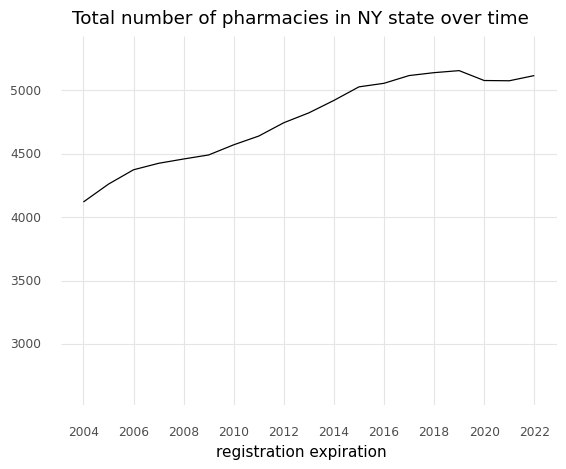

<ggplot: (314020105)>

In [51]:
def custom_format(breaks):
    fmt = '%Y'
    res = []
    for x in breaks:
        res.append(x.strftime(fmt))
    return res

to_plot_overall = count_opens(pd.to_datetime("2004-01-01"), 18, pharmacies_post_pbm)

display(
    ggplot(to_plot_overall)
    + aes(x='year', y='counts')
    + geom_line()
    + scale_x_datetime(breaks='2 year', labels=custom_format)
    + labs(title='Total number of pharmacies in NY state over time',
          x='registration expiration',
          y='')
    + theme_minimal()
    + theme(panel_grid_minor=element_blank())
    + ylim([2650, 5300]) #100% increase to match scales below
)

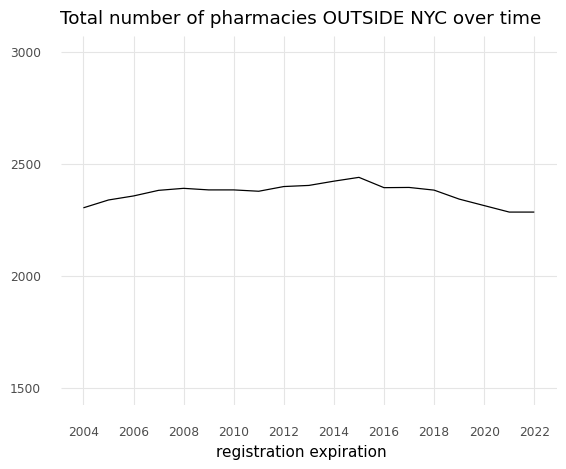

<ggplot: (314101610)>

In [52]:
to_plot_outside_nyc = count_opens(pd.to_datetime("2004-01-01"), 18, pharmacies_post_pbm.query('county.isin(@nyc) == False'))

display(
    ggplot(to_plot_outside_nyc)
    + aes(x='year', y='counts')
    + geom_line()
    + scale_x_datetime(breaks='2 year', labels=custom_format)
    + labs(title='Total number of pharmacies OUTSIDE NYC over time',
          x='registration expiration',
          y='')
    + ylim([1500, 3000]) #same scale as above
    + theme_minimal()
    + theme(panel_grid_minor=element_blank())
)

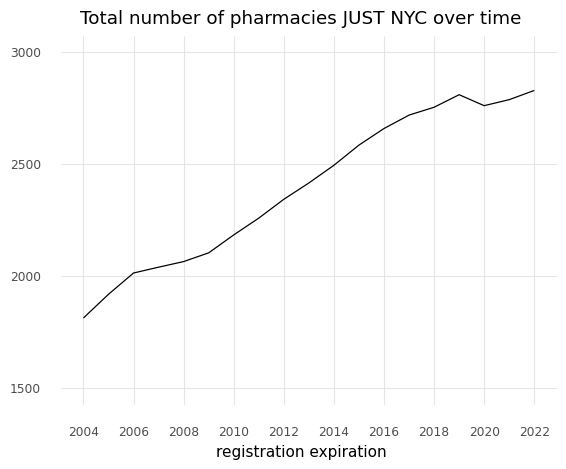

<ggplot: (311397040)>

In [53]:
to_plot_just_nyc = count_opens(pd.to_datetime("2004-01-01"), 18, pharmacies_post_pbm.query('county.isin(@nyc)'))

display(
    ggplot(to_plot_just_nyc)
    + aes(x='year', y='counts')
    + geom_line()
    + scale_x_datetime(breaks='2 year', labels=custom_format)
    + labs(title='Total number of pharmacies JUST NYC over time',
          x='registration expiration',
          y='')
    + ylim([1500, 3000]) #same scale as above
    + theme_minimal()
    + theme(panel_grid_minor=element_blank())
)

In [57]:
def count_opens_by_category(start_date, num_years, df):
    years = [start_date]
    for y in range(num_years):
        new_date = start_date + pd.DateOffset(years=1)
        start_date = new_date
        years.append(new_date)
    indep_counts = []
    healthcare_counts = []
    minor_chain_counts = []
    major_chain_counts = []
    public_owned_counts = []
    for year in years:
        #counts number that remained open throughout the year
        num_indep = df[(df.date_first_registered <= year) \
                        & (df.registration_ends > year) \
                        & (df.category == 'INDEPENDENT')].shape[0]
        num_health = df[(df.date_first_registered <= year) \
                        & (df.registration_ends > year) \
                        & (df.category == 'HEALTHCARE')].shape[0]
        num_minor = df[(df.date_first_registered <= year) \
                        & (df.registration_ends > year) \
                        & (df.category == 'MINOR CHAIN')].shape[0]
        num_major = df[(df.date_first_registered <= year) \
                        & (df.registration_ends > year) \
                        & (df.category == 'MAJOR CHAIN')].shape[0]
        num_public = df[(df.date_first_registered <= year) \
                        & (df.registration_ends > year) \
                        & (df.category == 'PUBLIC')].shape[0]
        indep_counts.append(num_indep)
        healthcare_counts.append(num_health)
        minor_chain_counts.append(num_minor)
        major_chain_counts.append(num_major)
        public_owned_counts.append(num_public)
    counts_df = {}
    counts_df['year'] = years
    counts_df['independent'] = indep_counts
    counts_df['major_chain'] = major_chain_counts
    counts_df['minor_chain'] = minor_chain_counts
    counts_df['healthcare'] = healthcare_counts
    counts_df['public_owned'] = public_owned_counts
    return pd.DataFrame(counts_df)

In [58]:
to_plot_cat = count_opens_by_category(pd.to_datetime("2004-01-01"), 18, pharmacies_post_pbm)

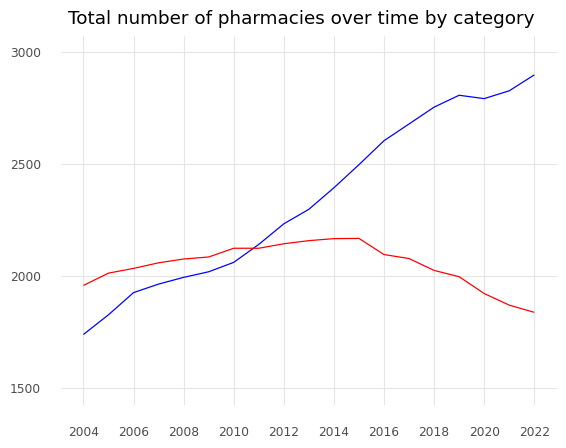

<ggplot: (291078988)>

In [59]:
display(
    ggplot(to_plot_cat)
    + geom_line(aes(x='year', y='independent'),color='blue')
    + geom_line(aes(x='year', y='major_chain'),color='red')
    #+ geom_line(aes(x='year', y='minor_chain'),color='purple')
    #+ geom_line(aes(x='year', y='healthcare'),color='green')
    #+ geom_line(aes(x='year', y='public_owned'),color='orange')
    + scale_x_datetime(breaks='2 year', labels=custom_format)
    + theme_minimal()
    + theme(panel_grid_minor=element_blank())
    + labs(title='Total number of pharmacies over time by category',
          y='', x='')
    + ylim([1500, 3000])
)

In [60]:
to_plot_no_city = count_opens_by_category(pd.to_datetime("2004-01-01"), 18, \
                                         pharmacies_post_pbm.query("county.isin(@nyc)==False"))

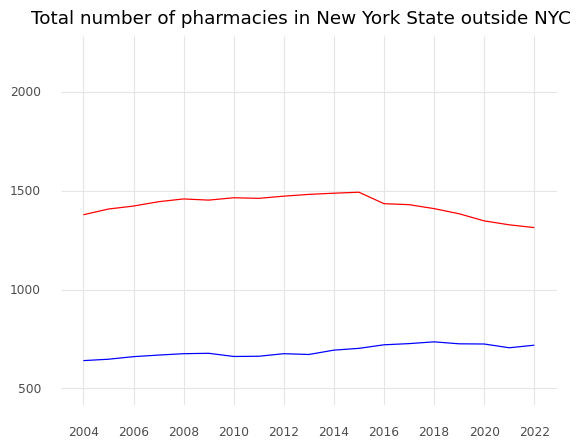

<ggplot: (314025798)>

In [61]:
display(
    ggplot(to_plot_no_city)
    + geom_line(aes(x='year', y='independent'),color='blue')
    + geom_line(aes(x='year', y='major_chain'),color='red')
    + labs(y='number of open pharmacies')
    #+ geom_line(aes(x='year', y='minor_chain'),color='purple')
    #+ geom_line(aes(x='year', y='healthcare'),color='green')
    #+ geom_line(aes(x='year', y='public_owned'),color='orange')
    + scale_x_datetime(breaks='2 year', labels=custom_format)
    + theme_minimal()
    + theme(panel_grid_minor=element_blank())
    + ylim([500, 2200]) #200% scale, same as below
    + labs(title='Total number of pharmacies in New York State outside NYC',
          y='', x='')
)

In [64]:
to_plot_just_city = count_opens_by_category(pd.to_datetime("2004-01-01"), 18, \
                                         pharmacies_post_pbm.query("county.isin(@nyc)"))

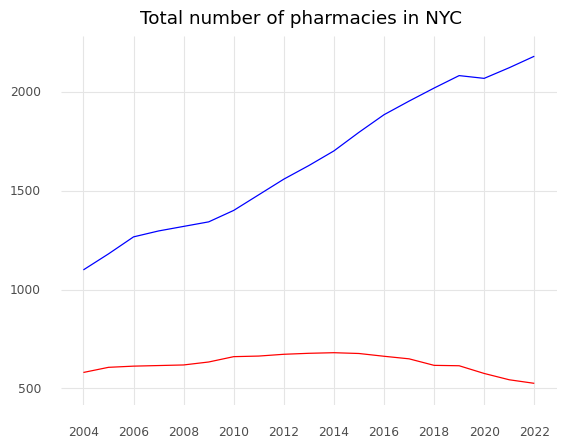

<ggplot: (314119132)>

In [65]:
display(
    ggplot(to_plot_just_city)
    + geom_line(aes(x='year', y='independent'),color='blue')
    + geom_line(aes(x='year', y='major_chain'),color='red')
    #+ geom_line(aes(x='year', y='minor_chain'),color='purple')
    #+ geom_line(aes(x='year', y='healthcare'),color='green')
    #+ geom_line(aes(x='year', y='public_owned'),color='orange')
    + scale_x_datetime(breaks='2 year', labels=custom_format)
    + theme_minimal()
    + theme(panel_grid_minor=element_blank())
    + ylim([500, 2200]) #200% scale
    + labs(title='Total number of pharmacies in NYC',
          y='', x='')
)